In [14]:
# importing required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import boxcox1p

from sklearn.compose import ColumnTransformer
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBRegressor

In [5]:
# loading data from source CSV files
stu_por = pd.read_csv('student-por.csv', sep=';')
stu_mat = pd.read_csv('student-mat.csv', sep=';')

In [6]:
pd.pandas.set_option('display.max_columns', None)

In [7]:
# merging data from both the files
stu=pd.concat([stu_por,stu_mat])

In [8]:
stu.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## Looking at each variable and try to understand their meaning and relevance to this problem

### Analysing 'absences'

In [9]:
stu['absences'].describe()

count    1044.000000
mean        4.434866
std         6.210017
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max        75.000000
Name: absences, dtype: float64

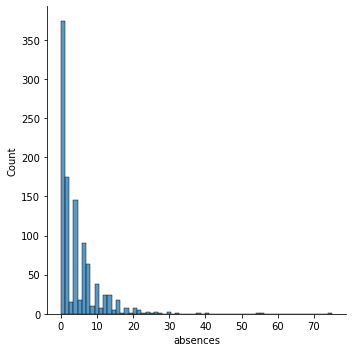

In [10]:
sns.displot(stu['absences'])

### Observation:
* Not normally distribution.
* Have positive skewness.
* Show peakedness.

In [11]:
print("Skewness: %f" % stu['absences'].skew())
print("Kurtosis: %f" % stu['absences'].kurt())

Skewness: 3.741347
Kurtosis: 26.596200


## Hypothesis Testing
p value <= 0.05

One Categorical Feature - sex:
H0 - There is no difference in the proportion of male and female
H1 - There is a difference in the proportion of male and female
Test - One Sample Proportion Test

Two Categorical Feature - sex based on Age
Test: Chi Square Test

One Numeric feature - absences
Test: T - Test

Two Numeric feature - absences
Test: Correlation

One Numerical variable and One catagorical variable - 
Anova Test

### T-Test

## Feature Engineering

## Missing data


In [12]:
#missing data
total = stu.isnull().sum().sort_values(ascending=False)
percent = (stu.isnull().sum()/stu.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
school,0,0.0
paid,0,0.0
G2,0,0.0
G1,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0
Dalc,0,0.0
goout,0,0.0
freetime,0,0.0


### Observation:
* Data is good from missing values stand point.
* All observations have values for all features.
* No imputation required.

### Univariate analysis

In [15]:
# standardizing data 
# mean of 0 and a standard deviation of 1.
absences_scaled = StandardScaler().fit_transform(stu['absences'][:,np.newaxis]);
low_range = absences_scaled[absences_scaled[:,0].argsort()][:30]
high_range= absences_scaled[absences_scaled[:,0].argsort()][-30:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]]

outer range (high) of the distribution:
[[ 2.18544272]
 [ 2.18544272]
 [ 2.34655006]
 [ 2.50765741]
 [ 2.50765741]
 [ 2.50765741]
 [ 2.50765741]
 [ 2.66876475]
 [ 2.66876475]
 [ 2.66876475]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.99097944]
 [ 3.15208678]
 [ 3.15208678]
 [ 3.31319412]
 [ 3.47430147]
 [ 3.47430147]
 [ 3.79651615]
 [ 4.11873084]
 [ 4.11873084]
 [ 4.44094553]
 [ 5.40758959]
 [ 5.72980427]
 [ 7.98530708]
 [ 8.30752177]
 [11.3685613 ]]


C:\Users\snara016\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Observation:
Low range values are similar and not too far from 0. High range values are far from 0 and the values above 2.something values are really out of range. We will take care of those outliers below

## Outliers

In [16]:
# dropping the records that have absences that are more than 18 because of less frequency
stu = stu.drop(stu[stu['absences']>18].index)

## Understading pattern in proportion of the absences with respect to other features

In [17]:
stu['abs_yes'] = stu['absences'] > 0

In [18]:
for feature in stu.columns:
    if feature != 'abs_yes' and feature != 'absences':
        print(stu.groupby(feature).agg({'abs_yes': ['mean', 'sum']}))

         abs_yes     
            mean  sum
school               
GP      0.669456  480
MS      0.580882  158
      abs_yes     
         mean  sum
sex               
F    0.640934  357
M    0.650463  281
      abs_yes     
         mean  sum
age               
15   0.605263  115
16   0.639405  172
17   0.647287  167
18   0.679426  142
19   0.640000   32
20   0.777778    7
21   0.500000    1
22   1.000000    2
          abs_yes     
             mean  sum
address               
R        0.648551  179
U        0.643759  459
          abs_yes     
             mean  sum
famsize               
GT3      0.647564  452
LE3      0.639175  186
          abs_yes     
             mean  sum
Pstatus               
A        0.684211   78
T        0.640000  560
       abs_yes     
          mean  sum
Medu               
0     0.250000    2
1     0.642487  124
2     0.647273  178
3     0.677273  149
4     0.631399  185
       abs_yes     
          mean  sum
Fedu               
0     0.555556    5
1

In [19]:
stu = stu.drop(columns=['abs_yes'])

# Feature Selection
## Numerical Features

## Correlation matrix (heatmap style)

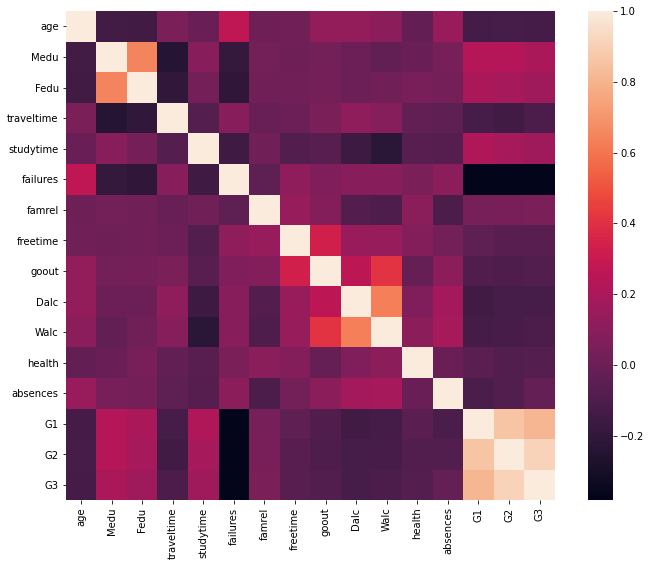

In [20]:
corrmat = stu.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

## Observation: 
* Grades G1,G2,G3 are highly correlated
* Alcohol consumption 'Dalc' and 'Walc' are correlated.

## 'absences' correlation matrix (zoomed heatmap style)
### Top 10 numerical feature that are correlated with absences

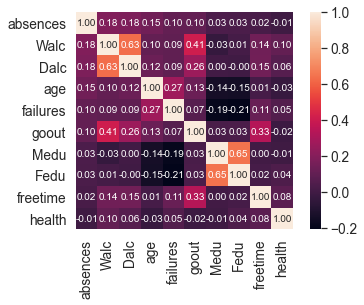

In [332]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'absences')['absences'].index
cm = np.corrcoef(stu[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Observation
### Expected to see some corellation with absences and other numeric feature. However not seeing much correction
* From the above matrix, we see 'Walc' and 'Dalc' are strongly correlated variables. 
* Also we see 'Medu' and 'Fedu' are correlated variables.

# Feature Selection
## Categorical Features

In [22]:
categorical_features = np.setdiff1d(stu.columns,corrmat.columns)

## Box Plots with Categorical features

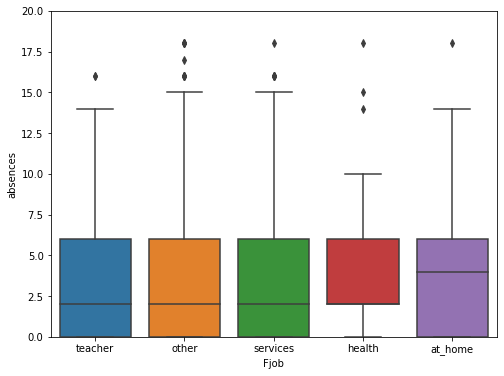

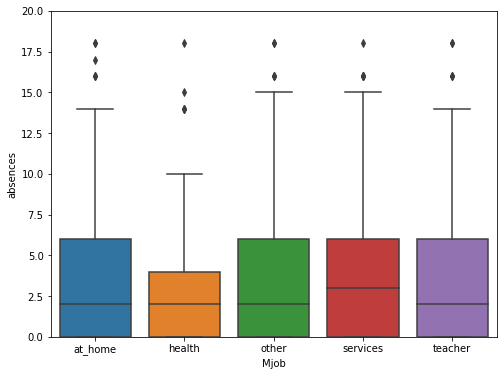

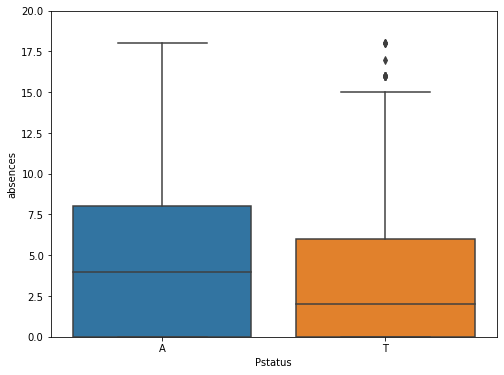

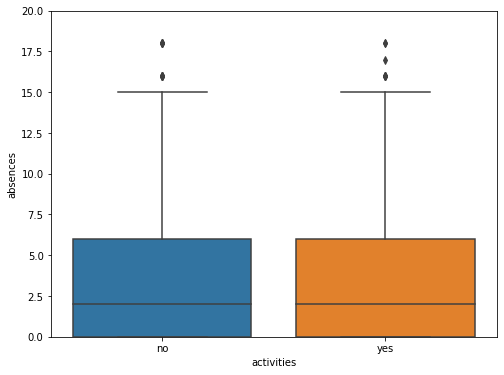

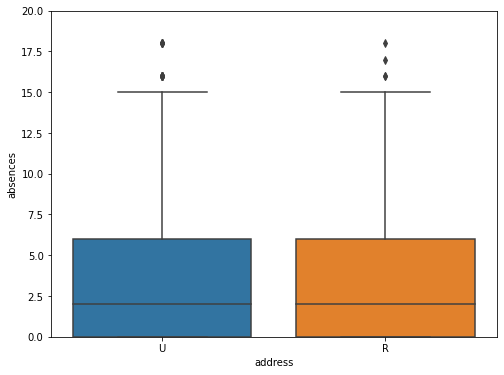

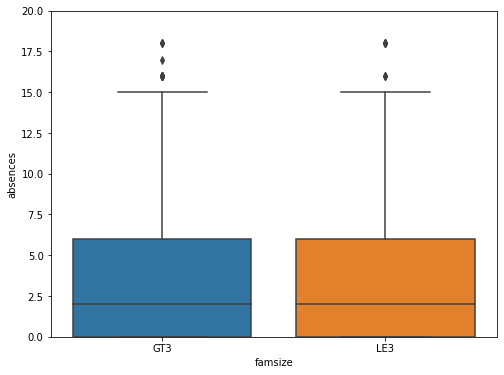

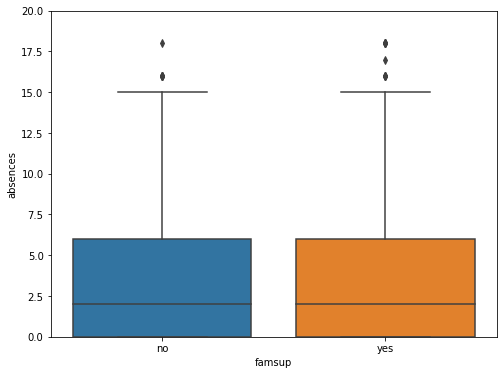

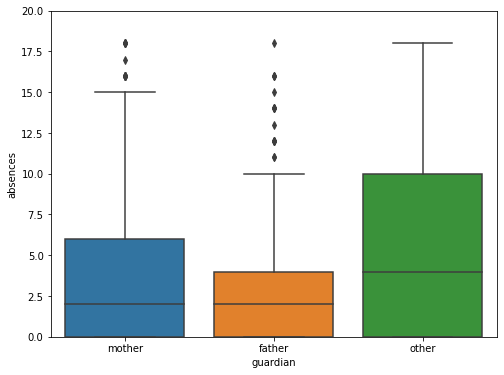

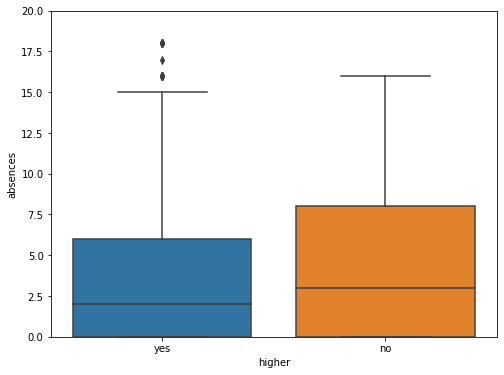

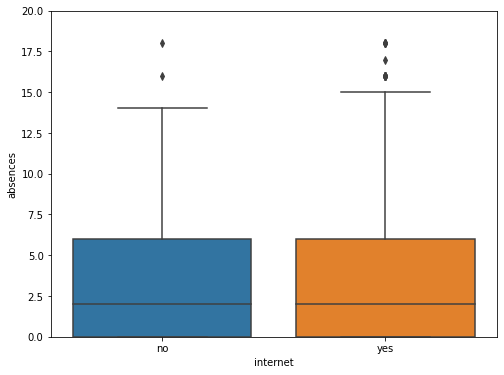

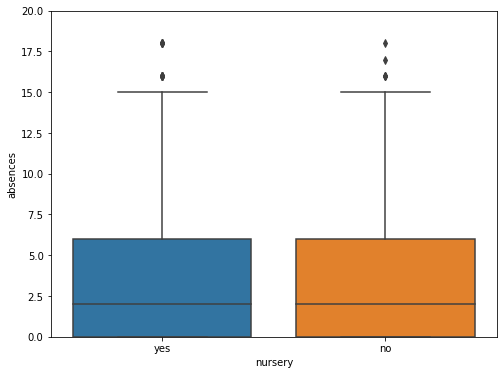

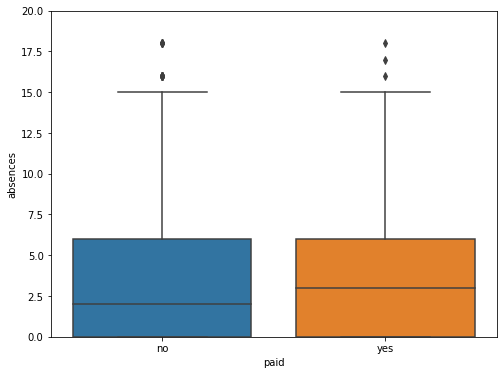

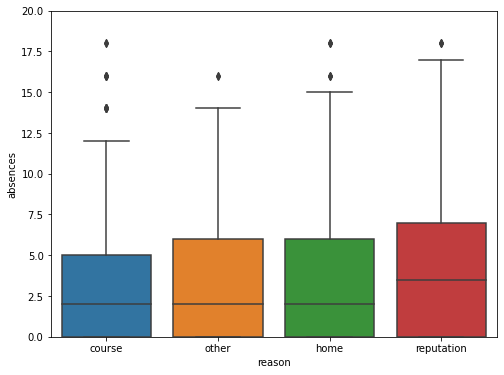

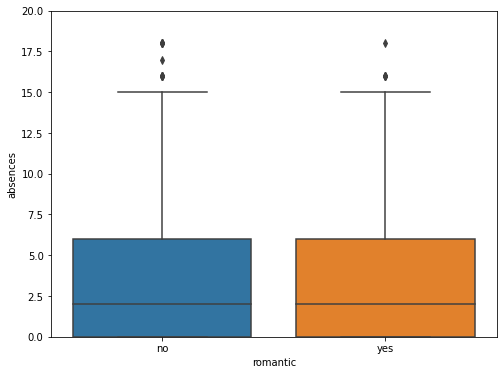

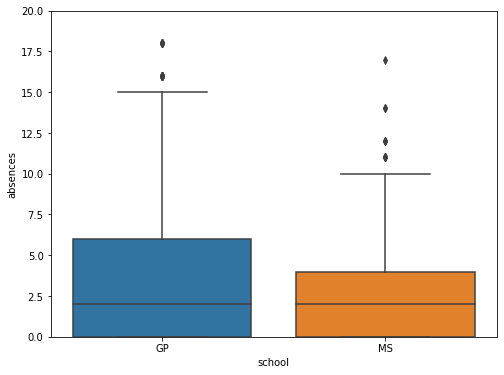

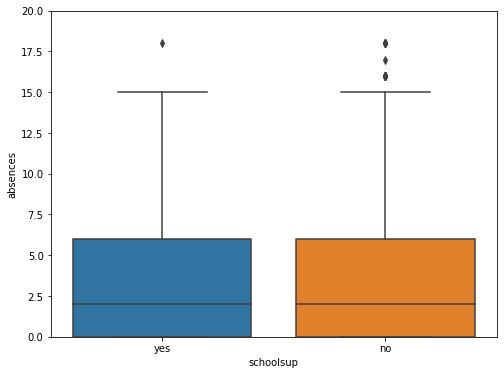

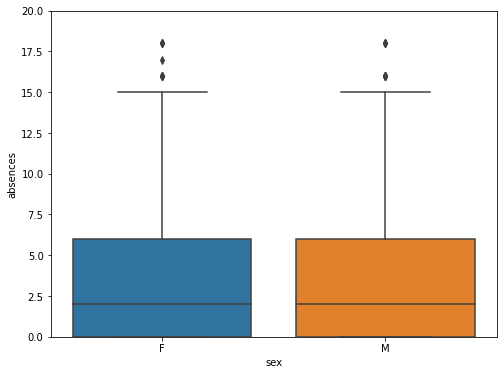

In [23]:
for feature in categorical_features:
        data = pd.concat([stu['absences'], stu[feature]], axis=1)
        f, ax = plt.subplots(figsize=(8,6))
        fig = sns.boxplot(x=feature, y='absences', data=data)
        fig.axis(ymin=0, ymax=20)

### Observation:
* same with categorical features as well. No much interesting relationships found. 
* From the above box plots, we see 'Mjob', 'Pstatus', 'guardian', 'higher', 'nursery', 'paid', 'reason', 'romantic' have some relation with absences. 

In [28]:
X = stu.drop(columns=['absences'])
y = stu['absences']

In [29]:
# One hot encoding
X = pd.get_dummies(X)
X = X.drop(columns = ['school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other', 'schoolsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes' ])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

In [31]:
X_train.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'G1', 'G2', 'G3',
       'school_GP', 'sex_F', 'address_R', 'famsize_GT3', 'Pstatus_A',
       'Mjob_at_home', 'Mjob_health', 'Mjob_services', 'Mjob_teacher',
       'Fjob_at_home', 'Fjob_health', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'schoolsup_no', 'famsup_no', 'famsup_yes', 'paid_no',
       'activities_no', 'nursery_no', 'higher_no', 'internet_no',
       'romantic_no'],
      dtype='object')

## Modeling 
* Mean squared error is used as Evaluation metrics for model selection

## ElasticNet Regression
ElasticNet is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods.

In [36]:
elasticNet_model = ElasticNet(random_state=0)

#### Hyperparameter tuning

In [37]:
search_space = [{'elasticNet_model': [elasticNet_model],
                    'elasticNet_model__max_iter': [1, 5, 10, 100, 1000],
                    'elasticNet_model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                    'elasticNet_model__l1_ratio': np.arange(0.0, 1.0, 0.1)}]

In [38]:
pipe0 = Pipeline(steps=[('elasticNet_model', elasticNet_model)])

In [39]:
elasticNet_GSCV = GridSearchCV(pipe0, search_space, cv=3, verbose=2, n_jobs = -1)

In [40]:
best_model_elasticNet = elasticNet_GSCV.fit(X_train, y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    5.4s finished


In [43]:
print(best_model_elasticNet.best_estimator_.get_params()['elasticNet_model'])

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=100, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)


In [44]:
y_pred_best_model_elasticNet = best_model_elasticNet.predict(X_test)

In [45]:
mse_elasticNetReg = metrics.mean_squared_error(y_test,y_pred_best_model_elasticNet)

In [47]:
print(mse_elasticNetReg)

16.25376925255867


## Observation:
* Mean Square Error is too high.

## RandomForest Regression
As ElasticNet regression did not go well. Trying Random Forest Regression uses ensemble learning method for regression trees.

In [51]:
RFReg = RandomForestRegressor(random_state=0)

#### Hyperparameter tuning

In [52]:
# Number of trees in random forest
n_estimators = [100, 200, 300, 500, 800, 1000, 1800]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2,4,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [53]:
search_space = [{'RFReg': [RFReg],
                    'RFReg__n_estimators': n_estimators,
                    'RFReg__max_features': max_features,
                    'RFReg__min_samples_split': min_samples_split,
                    'RFReg__min_samples_leaf': min_samples_leaf,
                    'RFReg__bootstrap': bootstrap}]

In [54]:
pipe1 = Pipeline(steps=[('RFReg', RFReg)])

In [55]:
RF_GSCV = GridSearchCV(pipe1, search_space, cv=3, verbose=2, n_jobs = -1)

In [56]:
best_model_RF = RF_GSCV.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:  5.8min finished


In [59]:
print(best_model_RF.best_estimator_.get_params()['RFReg'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [60]:
y_pred_best_model_RF = best_model_RF.predict(X_test)

In [61]:
rmse_RFBReg = metrics.mean_squared_error(y_test,y_pred_best_model_RF)

In [62]:
print(rmse_RFBReg)

14.761577975359492


## Observation:
* The result is not as exepceted
* However better that ElasticNet

## XGBRegressor


In [64]:
xgb_model = XGBRegressor(random_state=0)

#### Hyper Parameter tuning

In [65]:
search_space = [{'xgb_model': [xgb_model],
                    'xgb_model__learning_rate': [0.01, 0.1, 0.2, 0.3],
                    'xgb_model__max_depth': [3, 5, 7, 10],
                    'xgb_model__min_child_weight': [1, 3, 5],
                    'xgb_model__colsample_bytree': [0.5, 0.7],
                    'xgb_model__objective': ['reg:squarederror']}]

In [66]:
pipe2 = Pipeline(steps=[('xgb_model', xgb_model)])

In [67]:
XGB_GSCV = GridSearchCV(pipe2, search_space, cv=3, verbose=2, n_jobs = -1)

In [68]:
best_model_XGB = XGB_GSCV.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   26.7s finished


In [72]:
print(best_model_XGB.best_estimator_.get_params()['xgb_model'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [73]:
y_pred_best_model_XGB = best_model_XGB.predict(X_test)

In [74]:
rmse_XGBReg = metrics.mean_squared_error(y_test,y_pred_best_model_XGB)

In [75]:
print(rmse_XGBReg )

14.74519952006814


## Observation:
* The result is not as exepceted
* the result is similar to RandomForestRegressor

# Next steps:
Given more time, the following steps can be tried.
* Feature transformations
* Enhanced Hyperparameter tuning
* Trying other models

## Serving the Machine Learning Model as Rest API

* Serialie the finalized model into pickle file.
* Build a web API app using a Flask framework. This app will use the trained ML pickle file on new data points in real-time.
* Build the docker image Flask application.
* Upload the container onto Google Container Registry (GCR).
* Create a cluster on the Google Kubernetes Engine(GKE).
* Deploy the container image on the created cluseter and expose the app as the REST API to the public.
